Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn           # imports common layers
import torch.nn.functional as F # provides functional versions of activations like ReLU
import torch.optim as optim     # provides optimization algorithms like SGD
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import files
uploaded = files.upload()
from nn_manual import NNDropout , NNBatchNormalized , NNDropoutBatchNormalized

Saving nn_manual.py to nn_manual.py


**1. Data Preparation**

In [3]:
# a simple transform to convert images to tensors and normalize to [0,1]
transform = transforms.ToTensor()
# download MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.15MB/s]


In [4]:
# combine train+test to apply a custom stratified split
X_full = torch.cat([mnist_train.data, mnist_test.data], dim=0).float() / 255.0   # shape: (70000, 28, 28)
y_full = torch.cat([mnist_train.targets, mnist_test.targets], dim=0)

# data splitting
X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.20, stratify=y_full, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

Flatten Images

In [5]:
X_train_flat = X_train.reshape(-1, 28*28)
X_val_flat = X_val.reshape(-1, 28*28)
X_test_flat = X_test.reshape(-1, 28*28)

Create DataLoaders

In [6]:
train_loader = DataLoader(
    TensorDataset(X_train_flat, y_train),
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    TensorDataset(X_val_flat, y_val),
    batch_size=64,
    shuffle=False
)
test_loader = DataLoader(
    TensorDataset(X_test_flat, y_test),
    batch_size=64,
    shuffle=False
)


**2. Neural Network Implementation**

Architecture

In [ ]:
class CustomFeedforwardNN(nn.Module):
  # 1st hidden layer: 128 neurons, 2nd hidden layer: 64 neurons
    def __init__(self, input_size=784, hidden1_size=128, hidden2_size=64, output_size=10):

        super(CustomFeedforwardNN, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)

        # initialize weights with Xavier initialization (helps keep gradients stable)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        # initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x): # x is input tensor of size (batch size, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # output tensor of size (batch size, 10)


Training and Visualization

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model_once(model, train_loader, val_loader, epochs=10, learning_rate=0.01, device=device):
    model.to(device) # transfer to chosen device
    criterion = nn.CrossEntropyLoss()  # cross-entropy
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # SGD is used to optimize parameters
    # store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        # training mode (enable features like dropout)
        model.train()
        # initialize accumulators for batch loss, correct predictions and total samples processed
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # move batch inputs and labels to device
            optimizer.zero_grad()   # reset
            outputs = model(inputs) # forward pass
            loss = criterion(outputs, labels) # calculate loss comparing outputs to labels
            loss.backward()         # compute gradients via backpropagation
            optimizer.step()        # update model weights
            running_loss += loss.item() * inputs.size(0) # accumulate total loss (weighted by batch size)
            _, predicted = torch.max(outputs, 1) # calculate predicted class labels
            total += labels.size(0) # total samples processed
            correct += (predicted == labels).sum().item() # calculate correct predictions
        train_loss = running_loss / total
        train_acc = correct / total
        # validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_loss /= val_total
        val_acc = val_correct / val_total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")
    return train_losses, val_losses, train_accuracies, val_accuracies

Multiple Training Runs with Error Bars and Convergence Analysis

In [7]:
# run the training process multiple times according to runs variable
def train_multiple_times(model_class, train_loader, val_loader, epochs=10, learning_rate=0.01, runs=5):
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []

    for r in range(runs):
        print(f"\nRun {r+1}/{runs}")
        # independent model for each training run
        model = model_class()
        # collect training and validation losses and accuracies each run
        train_losses, val_losses, train_accuracies, val_accuracies = train_model_once(
            model, train_loader, val_loader, epochs, learning_rate, device)
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    # convert to numpy arrays for easier calculations
    all_train_losses = np.array(all_train_losses)
    all_val_losses = np.array(all_val_losses)
    all_train_accuracies = np.array(all_train_accuracies)
    all_val_accuracies = np.array(all_val_accuracies)

    # mean and std deviation for error bars
    mean_train_loss = np.mean(all_train_losses, axis=0)
    std_train_loss = np.std(all_train_losses, axis=0)
    mean_val_loss = np.mean(all_val_losses, axis=0)
    std_val_loss = np.std(all_val_losses, axis=0)
    mean_train_acc = np.mean(all_train_accuracies, axis=0)
    std_train_acc = np.std(all_train_accuracies, axis=0)
    mean_val_acc = np.mean(all_val_accuracies, axis=0)
    std_val_acc = np.std(all_val_accuracies, axis=0)

    # plot loss with error bars
    epochs_range = range(1, epochs + 1) # used for x-axis
    plt.figure(figsize=(10,5))
    plt.errorbar(epochs_range, mean_train_loss, yerr=std_train_loss, label='Training Loss')
    plt.errorbar(epochs_range, mean_val_loss, yerr=std_val_loss, label='Validation Loss')
    plt.title("Loss over Epochs with Error Bars")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # plot accuracy with error bars
    plt.figure(figsize=(10,5))
    plt.errorbar(epochs_range, mean_train_acc, yerr=std_train_acc, label='Training Accuracy')
    plt.errorbar(epochs_range, mean_val_acc, yerr=std_val_acc, label='Validation Accuracy')
    plt.title("Accuracy over Epochs with Error Bars")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # convergence analysis: find epoch where validation loss change is minimal
    val_loss_diff = np.abs(np.diff(mean_val_loss))
    convergence_epoch = np.argmin(val_loss_diff) + 1
    print(f"Convergence epoch: {convergence_epoch}")



Run 1/5
Epoch 1/10 Train Loss: 1.0479 Train Acc: 0.7395 Val Loss: 0.4985 Val Acc: 0.8689
Epoch 2/10 Train Loss: 0.4131 Train Acc: 0.8885 Val Loss: 0.3678 Val Acc: 0.8934
Epoch 3/10 Train Loss: 0.3348 Train Acc: 0.9055 Val Loss: 0.3162 Val Acc: 0.9099
Epoch 4/10 Train Loss: 0.2969 Train Acc: 0.9146 Val Loss: 0.2945 Val Acc: 0.9151
Epoch 5/10 Train Loss: 0.2707 Train Acc: 0.9225 Val Loss: 0.2675 Val Acc: 0.9249
Epoch 6/10 Train Loss: 0.2506 Train Acc: 0.9272 Val Loss: 0.2479 Val Acc: 0.9302
Epoch 7/10 Train Loss: 0.2346 Train Acc: 0.9324 Val Loss: 0.2349 Val Acc: 0.9341
Epoch 8/10 Train Loss: 0.2203 Train Acc: 0.9368 Val Loss: 0.2267 Val Acc: 0.9344
Epoch 9/10 Train Loss: 0.2082 Train Acc: 0.9405 Val Loss: 0.2159 Val Acc: 0.9377
Epoch 10/10 Train Loss: 0.1970 Train Acc: 0.9434 Val Loss: 0.2055 Val Acc: 0.9400

Run 2/5
Epoch 1/10 Train Loss: 1.0991 Train Acc: 0.7064 Val Loss: 0.5203 Val Acc: 0.8611
Epoch 2/10 Train Loss: 0.4276 Train Acc: 0.8827 Val Loss: 0.3723 Val Acc: 0.8955
Epoch 3/1

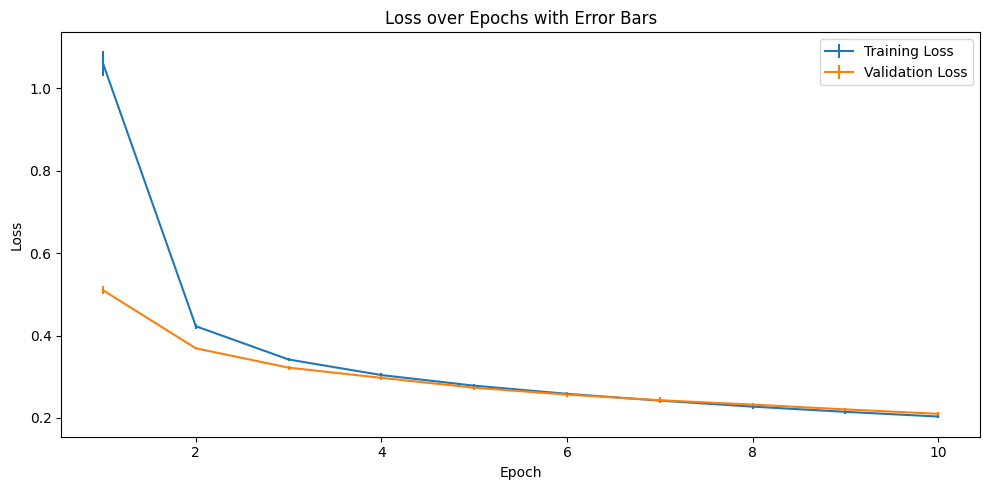

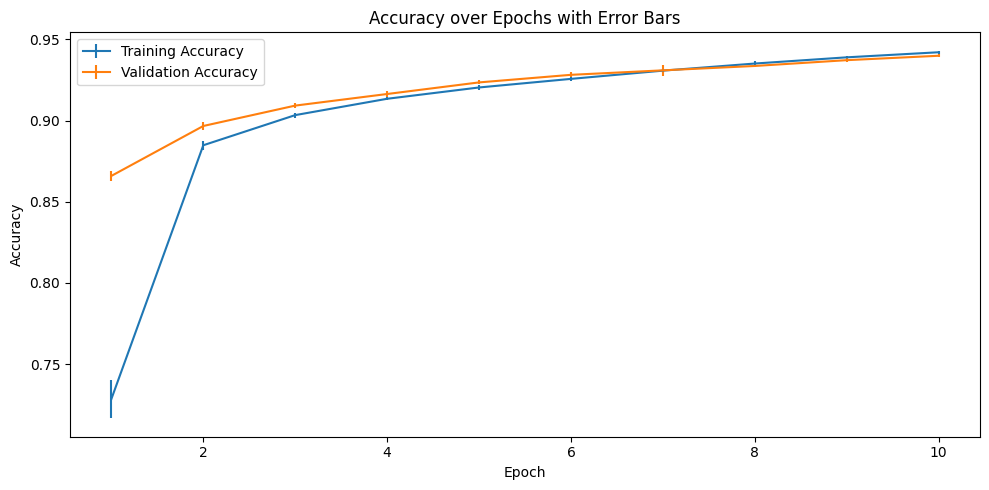

Convergence epoch: 7


In [ ]:
train_multiple_times(
    model_class=CustomFeedforwardNN,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    learning_rate=0.01,
    runs=5
)

# Part D2: NN with Dropout Layer

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dropout_rates = [0.1, 0.3, 0.5, 0.7]
dropout_results = {}

for rate in dropout_rates:
    print(f"Training with dropout rate: {rate}")
    model = NNDropout(dropout_rate=rate)

    train_losses, val_losses, train_accs, val_accs = train_model_once(
        model,
        train_loader,
        val_loader,
        epochs=10,
        learning_rate=0.01,
        device=device
    )
    dropout_results[rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs
    }


Training with dropout rate: 0.1
Epoch 1/10 Train Loss: 2.0068 Train Acc: 0.4711 Val Loss: 1.2998 Val Acc: 0.7376
Epoch 2/10 Train Loss: 0.8423 Train Acc: 0.7848 Val Loss: 0.5627 Val Acc: 0.8504
Epoch 3/10 Train Loss: 0.5216 Train Acc: 0.8501 Val Loss: 0.4245 Val Acc: 0.8849
Epoch 4/10 Train Loss: 0.4313 Train Acc: 0.8740 Val Loss: 0.3684 Val Acc: 0.8970
Epoch 5/10 Train Loss: 0.3888 Train Acc: 0.8889 Val Loss: 0.3396 Val Acc: 0.9031
Epoch 6/10 Train Loss: 0.3557 Train Acc: 0.8963 Val Loss: 0.3153 Val Acc: 0.9106
Epoch 7/10 Train Loss: 0.3335 Train Acc: 0.9024 Val Loss: 0.2988 Val Acc: 0.9164
Epoch 8/10 Train Loss: 0.3153 Train Acc: 0.9080 Val Loss: 0.2821 Val Acc: 0.9204
Epoch 9/10 Train Loss: 0.2967 Train Acc: 0.9152 Val Loss: 0.2665 Val Acc: 0.9249
Epoch 10/10 Train Loss: 0.2806 Train Acc: 0.9184 Val Loss: 0.2540 Val Acc: 0.9285
Training with dropout rate: 0.3
Epoch 1/10 Train Loss: 2.0758 Train Acc: 0.4066 Val Loss: 1.4611 Val Acc: 0.6886
Epoch 2/10 Train Loss: 1.0077 Train Acc: 0.7

## Dropout analysis

## Training Loss


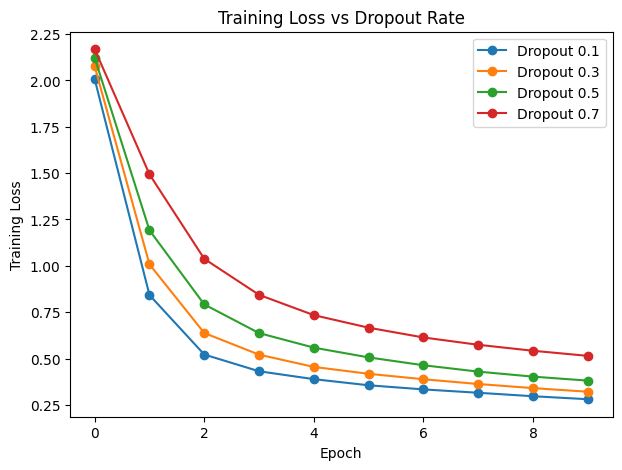

In [28]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results[rate]['train_losses'], label=f'Dropout {rate}', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Dropout Rate')
plt.legend()
plt.show()

## Validation Loss

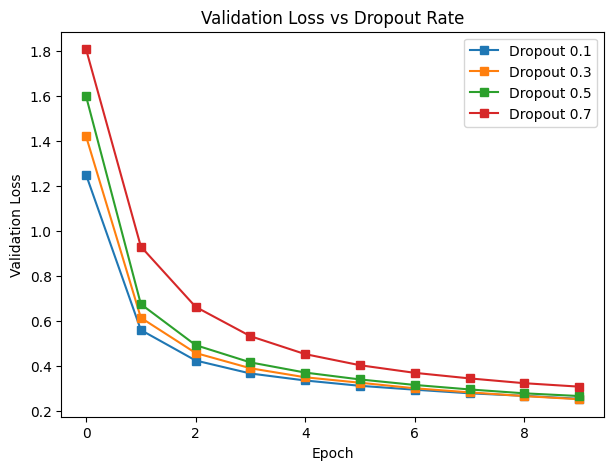

In [26]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results[rate]['val_losses'], label=f'Dropout {rate}', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Dropout Rate')
plt.legend()
plt.show()

## Batch Normalization

In [29]:
batchnorm_model = NNBatchNormalized()
batch_results=dict()

train_losses, val_losses, train_accs, val_accs = train_model_once(
    batchnorm_model, train_loader, val_loader,
    epochs=10, learning_rate=0.01, device=device
)

batch_results = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accs,
    'val_accuracies': val_accs
}

Epoch 1/10 Train Loss: 0.3961 Train Acc: 0.9009 Val Loss: 0.2063 Val Acc: 0.9461
Epoch 2/10 Train Loss: 0.1669 Train Acc: 0.9561 Val Loss: 0.1376 Val Acc: 0.9613
Epoch 3/10 Train Loss: 0.1174 Train Acc: 0.9688 Val Loss: 0.1152 Val Acc: 0.9675
Epoch 4/10 Train Loss: 0.0885 Train Acc: 0.9771 Val Loss: 0.1019 Val Acc: 0.9706
Epoch 5/10 Train Loss: 0.0701 Train Acc: 0.9816 Val Loss: 0.0962 Val Acc: 0.9716
Epoch 6/10 Train Loss: 0.0580 Train Acc: 0.9849 Val Loss: 0.0882 Val Acc: 0.9739
Epoch 7/10 Train Loss: 0.0474 Train Acc: 0.9885 Val Loss: 0.0891 Val Acc: 0.9728
Epoch 8/10 Train Loss: 0.0392 Train Acc: 0.9902 Val Loss: 0.1084 Val Acc: 0.9676
Epoch 9/10 Train Loss: 0.0347 Train Acc: 0.9920 Val Loss: 0.0871 Val Acc: 0.9744
Epoch 10/10 Train Loss: 0.0272 Train Acc: 0.9944 Val Loss: 0.0817 Val Acc: 0.9755


## NN With Dropout and Batch Normalization

In [30]:
dropout_rates = [0.1, 0.3, 0.5, 0.7]
dropout_results_both = {}

for rate in dropout_rates:
    print(f"Training with dropout rate: {rate}")
    model = NNDropoutBatchNormalized(dropout_rate=rate)

    train_losses, val_losses, train_accs, val_accs = train_model_once(
        model,
        train_loader,
        val_loader,
        epochs=10,
        learning_rate=0.01,
        device=device
    )
    dropout_results_both[rate] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accs,
        'val_accuracies': val_accs
    }


Training with dropout rate: 0.1
Epoch 1/10 Train Loss: 0.4289 Train Acc: 0.8898 Val Loss: 0.2031 Val Acc: 0.9457
Epoch 2/10 Train Loss: 0.1949 Train Acc: 0.9459 Val Loss: 0.1477 Val Acc: 0.9595
Epoch 3/10 Train Loss: 0.1438 Train Acc: 0.9598 Val Loss: 0.1238 Val Acc: 0.9631
Epoch 4/10 Train Loss: 0.1144 Train Acc: 0.9678 Val Loss: 0.1073 Val Acc: 0.9696
Epoch 5/10 Train Loss: 0.0937 Train Acc: 0.9738 Val Loss: 0.0949 Val Acc: 0.9721
Epoch 6/10 Train Loss: 0.0802 Train Acc: 0.9776 Val Loss: 0.0905 Val Acc: 0.9739
Epoch 7/10 Train Loss: 0.0687 Train Acc: 0.9813 Val Loss: 0.0858 Val Acc: 0.9761
Epoch 8/10 Train Loss: 0.0618 Train Acc: 0.9835 Val Loss: 0.0863 Val Acc: 0.9739
Epoch 9/10 Train Loss: 0.0554 Train Acc: 0.9844 Val Loss: 0.0811 Val Acc: 0.9757
Epoch 10/10 Train Loss: 0.0487 Train Acc: 0.9865 Val Loss: 0.0800 Val Acc: 0.9775
Training with dropout rate: 0.3
Epoch 1/10 Train Loss: 0.5079 Train Acc: 0.8635 Val Loss: 0.2192 Val Acc: 0.9406
Epoch 2/10 Train Loss: 0.2515 Train Acc: 0.9

## Analysis

## Training Loss

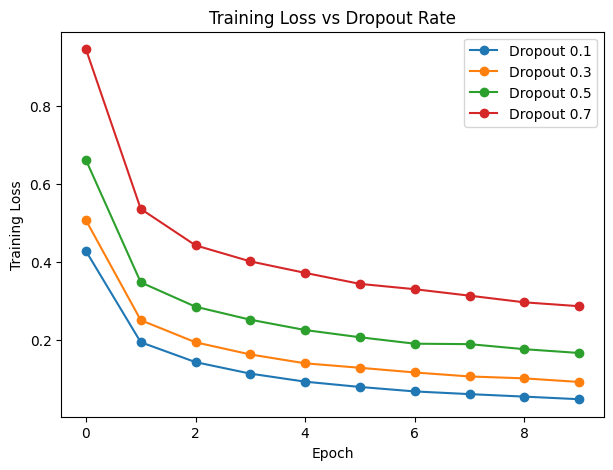

In [31]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results_both[rate]['train_losses'], label=f'Dropout {rate}', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Dropout Rate')
plt.legend()
plt.show()


## Validation Loss

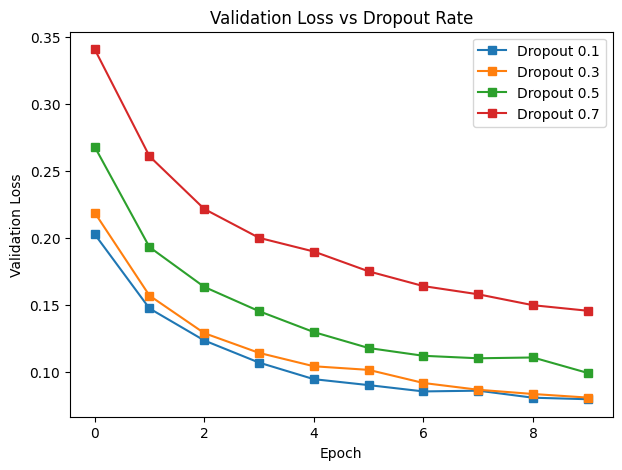

In [33]:
plt.figure(figsize=(7, 5))
for rate in dropout_rates:
    plt.plot(dropout_results_both[rate]['val_losses'], label=f'Dropout {rate}', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs Dropout Rate')
plt.legend()
plt.show()